In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 1. Setup

In [3]:
data_dir = "Data/OHLCV"
pattern = re.compile('[A-Z]+_[A-Z]+_[0-9a-z]+.csv')
data_fns = [fn for fn in os.listdir(data_dir) if pattern.match(fn)]
print(len(data_fns))
print(data_fns[:5])

194
['ADA_BTC_1h.csv', 'ADA_ETH_1h.csv', 'ADX_BTC_1h.csv', 'ADX_ETH_1h.csv', 'AION_BNB_1h.csv']


In [4]:
symbols = []
for fn in data_fns:
    symbol = [fn.split("_")[0], fn.split("_")[1]]
    symbols.append(symbol)
symbols = pd.DataFrame(symbols, columns=['Base-Coin', 'Quote-Coin'])
symbols.head()

,Base-Coin,Quote-Coin
0,ADA,BTC
1,ADA,ETH
2,ADX,BTC
3,ADX,ETH
4,AION,BNB


In [5]:
symbols['Quote-Coin'].value_counts()

BTC     84
ETH     77
BNB     27
USDT     6
Name: Quote-Coin, dtype: int64

In [6]:
data_fp = "Data/OHLCV/BNB_BTC_1h.csv"

In [7]:
data = pd.read_csv(data_fp)
data['Open-Time'] = pd.to_datetime(data['Open-Time'])
data['Close-Time'] = pd.to_datetime(data['Close-Time'])
print(data.shape)
data.head()

(20738, 12)


,Open-Time,Open,High,Low,Close,Volume,Close-Time,Quote-Asset-Value,Number-of-Trades,Taker-Buy-Base-Asset-Volume,Taker-Buy-Quote-Asset-Volume,Ignore
0,2018-01-01 00:00:00,0.000623,0.000625,0.000614,0.000618,130791.0,2018-01-01 00:59:59,80.955613,3328.0,54856.0,33.995884,0.0
1,2018-01-01 01:00:00,0.000618,0.000625,0.000611,0.000622,89072.0,2018-01-01 01:59:59,55.013318,2653.0,39926.0,24.693081,0.0
2,2018-01-01 02:00:00,0.000622,0.000625,0.000620,0.000622,101296.0,2018-01-01 02:59:59,63.078538,2663.0,59607.0,37.145069,0.0
3,2018-01-01 03:00:00,0.000622,0.000624,0.000619,0.000622,83701.0,2018-01-01 03:59:59,52.015837,2726.0,53257.0,33.115652,0.0
4,2018-01-01 04:00:00,0.000622,0.000628,0.000622,0.000625,103000.0,2018-01-01 04:59:59,64.458631,2921.0,55663.0,34.841113,0.0


## 2. Define Dataset

In [8]:
class MarketDataset(Dataset):
    
    def __init__(self, base_coin, quote_coin, min_time, max_time, resolution, lookback_period, forecast_period, mode):
        self.base_coin = base_coin
        self.quote_coin = quote_coin
        data_fn = "{}_{}_1h.csv".format(base_coin, quote_coin)
        data_fp = os.path.join(data_dir, data_fn)
        self.data = pd.read_csv(data_fp)
        self.data['Open-Time'] = pd.to_datetime(self.data['Open-Time'])
        self.data['Close-Time'] = pd.to_datetime(self.data['Close-Time'])
        self.data = self.data[self.data['Open-Time'] >= min_time]
        self.data = self.data[self.data['Close-Time'] <= max_time]
        self.data = self.change_resolution(self.data, resolution=resolution)
        self.lookback_period = lookback_period # 24
        self.forecast_period = forecast_period # 6
        self.sequence_length = lookback_period + forecast_period # 30
        self.mode = mode # ['train', 'test', 'predict']
        if self.mode == 'predict':
            assert self.forecast_period == 1
        self.start_indices = self.find_valid_start_indices()
        self.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        self.price_columns = ['Open', 'High', 'Low', 'Close']   
        
    def aggregate_rows(self, data):
        row = {}
        row['Open-Time'] = data['Open-Time'].values[0]
        row['Close-Time'] = data['Close-Time'].values[-1]
        row['Open'] = data['Open'].values[0]
        row['Close'] = data['Close'].values[-1]
        row['High'] = data['High'].max()
        row['Low'] = data['Low'].min()
        sum_columns = ['Volume', 'Number-of-Trades', 'Taker-Buy-Base-Asset-Volume', 'Taker-Buy-Quote-Asset-Volume', 'Ignore']
        for column in sum_columns:
            row[column] = data[column].sum()
        row['Quote-Asset-Value'] = data['Quote-Asset-Value'].mean()
        return row

    def change_resolution(self, data, resolution):
        if resolution == "1h":
            return data
        elif resolution[-1] == 'h':
            n = int(resolution[:-1])
            if 24 % n != 0:
                raise ValueError("Not Defined")
        elif resolution[-1] == 'd':
            n = int(resolution[:-1]) * 24

        new_data = pd.DataFrame(columns=data.columns)
        for start_i in tqdm(range(0, len(data), n), desc="Changing Resolution"):
            row = self.aggregate_rows(data.iloc[start_i: start_i+n, :])
            new_data = new_data.append(row, ignore_index=True)
        return new_data
        
    def find_valid_start_indices(self):
        if self.mode in ['train', 'test']:
            total_length = len(self.data) - self.sequence_length + 1 # 40 - 30 + 1
        elif self.mode == "predict":
            total_length = len(self.data) - self.lookback_period + 1 # 40 - 24 + 1 
        print("Finding valid indices...")
        start_indices = [start_index for start_index in range(total_length) if self.is_valid(start_index)]
        print("Done")
        return start_indices
    
    def is_valid(self, start_index):
        if self.mode in ['train', 'test']:
            XY = self.data.iloc[start_index: start_index+self.sequence_length]
        elif self.mode == "predict":
            XY = self.data.iloc[start_index: start_index+self.lookback_period]
        has_na = XY.isna().any().any()
        return np.invert(has_na)
        
    def __len__(self):
        return len(self.start_indices)
    
    def __getitem__(self, index):
        start_index = self.start_indices[index]
        encoder_end_time = self.data.iloc[start_index+self.lookback_period-1]['Open-Time']
        encoder_x = self.data.iloc[start_index: start_index+self.lookback_period][self.columns]
        decoder_x = self.data.iloc[start_index+self.lookback_period-1: start_index+self.sequence_length-1][self.columns]
        if self.mode in ['train', 'test']:
            decoder_y = self.data.iloc[start_index+self.lookback_period: start_index+self.sequence_length][self.columns]
        
        min_price = encoder_x['Low'].min()
        max_price = encoder_x['High'].max()
        min_volume = encoder_x['Volume'].min()
        max_volume = encoder_x['Volume'].max()

        encoder_x[self.price_columns] = (encoder_x[self.price_columns] - min_price) / (max_price - min_price)
        encoder_x['Volume'] = (encoder_x['Volume'] - min_volume) / (max_volume - min_volume)
        encoder_x = torch.from_numpy(encoder_x.values)
        
        decoder_x[self.price_columns] = (decoder_x[self.price_columns] - min_price) / (max_price - min_price)
        decoder_x['Volume'] = (decoder_x['Volume'] - min_volume) / (max_volume - min_volume)
        decoder_x = torch.from_numpy(decoder_x.values)
        
        if self.mode in ['train', 'test']:
            decoder_y[self.price_columns] = (decoder_y[self.price_columns] - min_price) / (max_price - min_price)
            decoder_y['Volume'] = (decoder_y['Volume'] - min_volume) / (max_volume - min_volume)
            decoder_y = torch.from_numpy(decoder_y.values)
            return encoder_x, decoder_x, decoder_y
        
        normalizing_parameters = [min_price, max_price, min_volume, max_volume]
        return encoder_x, decoder_x, encoder_end_time, normalizing_parameters

In [9]:
base_coin = "BNB"
quote_coin = "BTC"
dt_format = "%Y-%m-%dT%H:%M:%S"
min_time = "2018-01-01T00:00:00"
max_time = "2020-01-01T00:00:00"
resolution = "1d"
lookback_period = 30
forecast_period = 4
mode = 'train'

min_time = pd.to_datetime(min_time, format=dt_format)
max_time = pd.to_datetime(max_time, format=dt_format)

In [10]:
dataset = MarketDataset(base_coin=base_coin, 
                        quote_coin=quote_coin, 
                        min_time=min_time, 
                        max_time=max_time, 
                        resolution=resolution,
                        lookback_period=lookback_period, 
                        forecast_period=forecast_period,
                        mode=mode)


Finding valid indices...
Done


In [11]:
print(len(dataset))
dataset[180]

479


(tensor([[0.4378, 0.4843, 0.3141, 0.4324, 0.2177],
         [0.4259, 0.5135, 0.1622, 0.2589, 0.1918],
         [0.2535, 0.4476, 0.2049, 0.3735, 0.3648],
         [0.3649, 0.4081, 0.2097, 0.2811, 0.2652],
         [0.2795, 0.5405, 0.2741, 0.4405, 0.4796],
         [0.4346, 0.5535, 0.3070, 0.4276, 0.2838],
         [0.4276, 0.5205, 0.2903, 0.3946, 0.0031],
         [0.3941, 0.4968, 0.3378, 0.4243, 0.1141],
         [0.4232, 0.4486, 0.3032, 0.3416, 0.0000],
         [0.3416, 0.4086, 0.1357, 0.2973, 0.0242],
         [0.2968, 0.3719, 0.1827, 0.3016, 0.0056],
         [0.3000, 0.3784, 0.2449, 0.3476, 0.4451],
         [0.3476, 0.3751, 0.1946, 0.3076, 0.2295],
         [0.3076, 0.4265, 0.2281, 0.2962, 0.2994],
         [0.2854, 0.3622, 0.2605, 0.2838, 0.3243],
         [0.2870, 0.3508, 0.2627, 0.3254, 0.2802],
         [0.3227, 0.9303, 0.2886, 0.6751, 1.0000],
         [0.6751, 0.8589, 0.5676, 0.6135, 0.5962],
         [0.6135, 0.7162, 0.5459, 0.6616, 0.4649],
         [0.6595, 1.0000, 0.627

In [12]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_iter = iter(data_loader)
encoder_X, decoder_X, decoder_Y = next(data_iter)
print(encoder_X.shape, decoder_X.shape,  decoder_Y.shape)

torch.Size([32, 30, 5]) torch.Size([32, 4, 5]) torch.Size([32, 4, 5])


## 3. Define the model

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
    def init_hidden(self, batch_size):
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).double().to(device)
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size)).double().to(device)
        return (h0, c0)
    
    def forward(self, X):
        h0, c0 = self.init_hidden(X.size(0))
        out, (ht, ct) = self.lstm(X, (h0, c0)) # out -> [batch_size, time_steps, hidden_size]
        return out, (ht, ct)

In [14]:
class Decoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, 
                             hidden_size=hidden_size, 
                             num_layers=num_layers, 
                             batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, Y, hidden):
        h0, c0 = hidden
        out, (ht, ct) = self.lstm(Y, (h0, c0)) # out -> [batch_size, time_steps, hidden_size]
        out = F.relu(self.fc(out))
        return out, (ht, ct)

In [15]:
input_size = 5
hidden_size = 32
num_layers = 1
output_size = 5

In [16]:
encoder = Encoder(input_size=input_size,
                  hidden_size=hidden_size, 
                  num_layers=num_layers).double()
decoder = Decoder(input_size=input_size,
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  output_size=output_size).double()

In [17]:
encoder_X, decoder_X, decoder_Y = next(data_iter)
print(encoder_X.shape, decoder_X.shape,  decoder_Y.shape)
out, (ht, ct) = encoder(encoder_X)
print(out.shape, ht.shape, ct.shape)
hidden = (ht, ct)
out, (ht, ct) = decoder(decoder_X, hidden)
print(out.shape, ht.shape, ct.shape)

torch.Size([32, 30, 5]) torch.Size([32, 4, 5]) torch.Size([32, 4, 5])
torch.Size([32, 30, 32]) torch.Size([1, 32, 32]) torch.Size([1, 32, 32])
torch.Size([32, 4, 5]) torch.Size([1, 32, 32]) torch.Size([1, 32, 32])


## 3. Define Training 

In [18]:
epochs = 10
print_every_n_epochs = epochs // 10
lr = 0.01
step_size = len(data_loader) * 1
gamma = 0.95
print(step_size)

15


In [19]:
criterion = nn.MSELoss(reduction='mean')
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [20]:
def compute_loss(decoder_Y_pred, decoder_Y, weights):
    weights = np.array(weights) 
    weights = weights / weights.sum()
    loss = 0
    for i, weight in enumerate(weights):
        loss = loss + weight * criterion(decoder_Y_pred[:,:,i], decoder_Y[:,:,i])
    return loss

In [21]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []
weights = [1, 1, 1, 1, 1]

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0
    
    for i, (encoder_X, decoder_X, decoder_Y) in tqdm(enumerate(data_loader, 1), leave=False, total=len(data_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        encoder_X, decoder_X, decoder_Y = encoder_X.to(device), decoder_X.to(device), decoder_Y.to(device)
        

        optimizer.zero_grad()
        out, hidden = encoder(encoder_X)
        decoder_Y_pred, (ht, ct) = decoder(decoder_X, hidden) # out: [batch_size, timesteps, features]
        loss = compute_loss(decoder_Y_pred, decoder_Y, weights)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_last_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_last_lr()[0]
        
    epoch_loss /= len(data_loader)
    epoch_lr /= len(data_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)

Epoch:1    Loss:0.24585168128897264    LR:0.009966666666666667


Epoch:2    Loss:0.14125259678197372    LR:0.009468333333333332


Epoch:3    Loss:0.12994067987174815    LR:0.008994916666666667


Epoch:4    Loss:0.12530574529975239    LR:0.008545170833333336


Epoch:5    Loss:0.12228546752118184    LR:0.008117912291666664


Epoch:6    Loss:0.1209939225770585    LR:0.007712016677083334


Epoch:7    Loss:0.12049300506051616    LR:0.007326415843229166


Epoch:8    Loss:0.12006888171844789    LR:0.006960095051067706


Epoch:9    Loss:0.11974944193875288    LR:0.00661209029851432


Epoch:10    Loss:0.11972873929020661    LR:0.006281485783588604



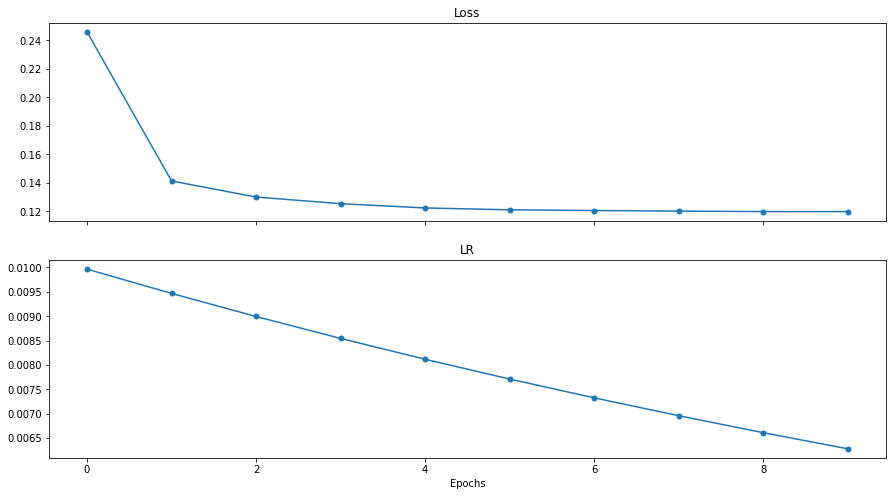

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

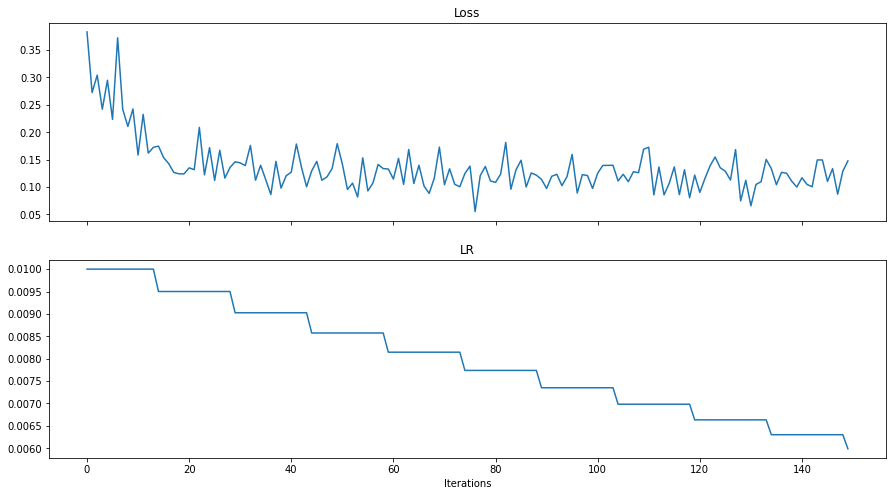

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

In [24]:
parameters = [base_coin, quote_coin, resolution, lookback_period, forecast_period]
model_fn = "{}_{}_{}_{}_{}.pth".format(*parameters)
model_fp = os.path.join("Models", "OHLCV", model_fn)
print(model_fp)

Models/OHLCV/BNB_BTC_1d_30_4.pth


In [25]:
model = {}
model['encoder'] = encoder.state_dict()
model['decoder'] = decoder.state_dict()
torch.save(model, model_fp)

## 4. Define prediction

In [26]:
base_coin = "BNB"
quote_coin = "BTC"
dt_format = "%Y-%m-%dT%H:%M:%S"
min_time = "2020-04-01T00:00:00"
max_time = "2020-05-30T00:00:00"
resolution = "1d"
lookback_period = 30
forecast_period_train = 4
forecast_period_predict = 1###
mode = 'predict'

min_time = pd.to_datetime(min_time, format=dt_format)
max_time = pd.to_datetime(max_time, format=dt_format)

In [27]:
dataset = MarketDataset(base_coin=base_coin, 
                        quote_coin=quote_coin, 
                        min_time=min_time, 
                        max_time=max_time, 
                        resolution=resolution,
                        lookback_period=lookback_period, 
                        forecast_period=forecast_period_predict,
                        mode=mode)
print(len(dataset))


Finding valid indices...
Done
13


In [28]:
encoder_x, decoder_x, encoder_end_time, _ = dataset[12]
print(encoder_x.shape, decoder_x.shape, encoder_end_time)

torch.Size([30, 5]) torch.Size([1, 5]) 2020-05-12 00:00:00


In [29]:
parameters = [base_coin, quote_coin, resolution, lookback_period, forecast_period_train]
model_fn = "{}_{}_{}_{}_{}.pth".format(*parameters)
model_fp = os.path.join("Models", "OHLCV", model_fn)
model = torch.load(model_fp)

In [30]:
encoder = Encoder(input_size=input_size,
                  hidden_size=hidden_size, 
                  num_layers=num_layers).double()
encoder.load_state_dict(model['encoder'])
encoder.eval()
decoder = Decoder(input_size=input_size,
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  output_size=output_size).double()
decoder.load_state_dict(model['decoder'])
decoder.eval()

Decoder(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

In [42]:
predictions = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
index = 12#len(dataset)-1
encoder_x, decoder_x, encoder_end_time, normalizing_parameters = dataset[index]
min_price, max_price, min_volume, max_volume = normalizing_parameters
print(encoder_end_time, resolution)
encoder_X = encoder_x.unsqueeze(0)
decoder_X = decoder_x.unsqueeze(0)
out, hidden = encoder(encoder_X)
for j in range(forecast_period_train):
    decoder_Y_pred, hidden = decoder(decoder_X, hidden)
    decoder_X = decoder_Y_pred
    prediction = {}
    prediction['Open'] = decoder_Y_pred[0, 0, 0].item() * (max_price - min_price) + min_price
    prediction['High'] = decoder_Y_pred[0, 0, 1].item() * (max_price - min_price) + min_price
    prediction['Low'] = decoder_Y_pred[0, 0, 2].item() * (max_price - min_price) + min_price
    prediction['Close'] = decoder_Y_pred[0, 0, 3].item() * (max_price - min_price) + min_price
    prediction['Volume'] = decoder_Y_pred[0, 0, 4].item() * (max_volume - min_volume) + min_volume
    predictions = predictions.append(prediction, ignore_index=True)
print(predictions)

2020-05-12 00:00:00 1d
       Open     High       Low     Close         Volume
0  0.001766  0.00167  0.001726  0.001768  632682.781867
1  0.001748  0.00167  0.001715  0.001750  723062.988761
2  0.001731  0.00167  0.001702  0.001734  793327.105226
3  0.001717  0.00167  0.001690  0.001720  849473.010710
